# [転移学習と微調整](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ja)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset  = image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
class_names = train_dataset.class_names

print(class_names)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['cats', 'dogs']


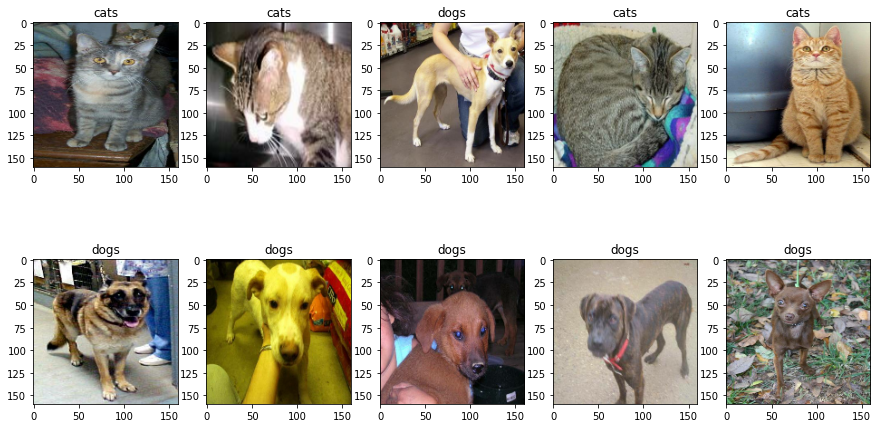

In [23]:
fig = plt.figure(figsize=(15,8))
for images, labels in train_dataset.take(1):
    for x in range(0,10):
        fig.add_subplot(2,5,x+1)
        plt.imshow(images[x].numpy().astype('uint8'))
        plt.title(class_names[labels[x]])

# Data preprocessing

In [37]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches //5)

print(val_batches)
print(val_batches / 5)
print(val_batches // 5)
print(test_dataset)
print(validation_dataset)

tf.Tensor(32, shape=(), dtype=int64)
tf.Tensor(6.4, shape=(), dtype=float64)
tf.Tensor(6, shape=(), dtype=int64)
<TakeDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>


In [40]:
AUTOTUNE = tf.data.AUTOTUNE ## tf.data.AUTOTUNE = -1

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data expansion
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

## pre-scaling
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Modeling

In [45]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# don't update parameters on layers
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [48]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layers = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layers(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5, 5, 1280)
(32, 1280)
(32, 1)


In [49]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [50]:
initial_epochs = 10

loss0, acccuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 12s 386ms/step - loss: 0.7174 - accuracy: 0.5331


In [51]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 43s 628ms/step - loss: 0.6924 - accuracy: 0.5750 - val_loss: 0.4931 - val_accuracy: 0.7215
Epoch 2/10
63/63 [==============================] - 39s 617ms/step - loss: 0.5054 - accuracy: 0.7265 - val_loss: 0.3629 - val_accuracy: 0.8205
Epoch 3/10
63/63 [==============================] - 39s 621ms/step - loss: 0.4219 - accuracy: 0.7970 - val_loss: 0.2889 - val_accuracy: 0.8973
Epoch 4/10
63/63 [==============================] - 39s 615ms/step - loss: 0.3556 - accuracy: 0.8350 - val_loss: 0.2334 - val_accuracy: 0.9257
Epoch 5/10
63/63 [==============================] - 39s 617ms/step - loss: 0.3084 - accuracy: 0.8645 - val_loss: 0.2036 - val_accuracy: 0.9295
Epoch 6/10
63/63 [==============================] - 39s 612ms/step - loss: 0.2876 - accuracy: 0.8780 - val_loss: 0.1764 - val_accuracy: 0.9418
Epoch 7/10
63/63 [==============================] - 39s 608ms/step - loss: 0.2534 - accuracy: 0.8880 - val_loss: 0.1595 - val_accuracy: 0.9468

# Fine Tuning

In [54]:
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
model.compile(optimizer = keras.optimizers.RMSprop(lr=1e-6), loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [57]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs = total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 61s 885ms/step - loss: 0.2065 - accuracy: 0.9025 - val_loss: 0.1057 - val_accuracy: 0.9616
Epoch 11/20
63/63 [==============================] - 54s 858ms/step - loss: 0.1807 - accuracy: 0.9165 - val_loss: 0.0836 - val_accuracy: 0.9715
Epoch 12/20
63/63 [==============================] - 56s 877ms/step - loss: 0.1591 - accuracy: 0.9332 - val_loss: 0.0831 - val_accuracy: 0.9715
Epoch 13/20
63/63 [==============================] - 54s 848ms/step - loss: 0.1564 - accuracy: 0.9357 - val_loss: 0.0744 - val_accuracy: 0.9752
Epoch 14/20
63/63 [==============================] - 53s 845ms/step - loss: 0.1462 - accuracy: 0.9414 - val_loss: 0.0615 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 54s 851ms/step - loss: 0.1320 - accuracy: 0.9456 - val_loss: 0.0672 - val_accuracy: 0.9765
Epoch 16/20
63/63 [==============================] - 54s 854ms/step - loss: 0.1513 - accuracy: 0.9318 - val_loss: 0.0642 - val_accuracy: